In [1]:
import pandas as pd
import numpy as np

import scipy.io as sio
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams['font.size'] = 8.0
matplotlib.rcParams['pdf.fonttype'] = 42

In [2]:
def getEnsembleMeanStd(tps, WhiteNoise, TimeHistory, TimePost = 0):
    ensemble = []
    for idx, ind in enumerate(tps):
        stimulus = WhiteNoise.values[int(ind*Fs-TimeHistory*Fs):int(ind*Fs + TimePost*Fs)]
        ensemble.append(stimulus)
        df = pd.DataFrame({'data': ensemble})

    # the columns are timepoints and rows each new Stimulus history
    expand = df.data.apply(pd.Series)
    if 660 in list(expand.columns):
        expand.drop([660],axis = 1, inplace = True)
    mean = expand.mean(axis = 0)
    std = expand.std(axis = 0)
    return(expand, mean, std)

In [3]:
# input all parameters
Fs = 3e4
TimeHistory = 20e-3 # in seconds
TimePost = 2e-3 # in seconds

In [4]:
# read in the timestamps
name = 'm10_whiteNoise_2'
import pickle
filename = './dataFolder/' + name + '_timeStamps.pickle'
with open(filename, "rb") as f:
    testout = pickle.load(f)
all_Units_aligned = testout[0]
all_Units_prior = testout[1]
WhiteNoise = testout[2]

In [5]:
# get the sta and ste
ste = {}
sta = {}
sta_error = {}
for k in all_Units_aligned.keys():
#     print(k)
    unit_tp = np.concatenate(all_Units_aligned[k], axis = 0)
    ste[k], sta[k], sta_error[k] = getEnsembleMeanStd(unit_tp, WhiteNoise, TimeHistory, TimePost)

    time_axis = np.arange(-TimePost, TimeHistory, 1/Fs)
    f = plt.figure()
    plt.plot(time_axis, np.flip(sta[k]), 'k')

    plt.fill_between(time_axis
                     , np.flip(sta[k]-sta_error[k]), np.flip(sta[k]+sta_error[k]))
    plt.xlim(0.02, -0.002)
    filename = './dataFolder/' + name + '_' + k + '_STA.pdf'
    plt.savefig(filename)
    plt.clf()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [6]:
prior_ensemble = {}
prior_mean = {}
prior_error = {}
for k in all_Units_prior.keys():
    unit_tp = np.concatenate(all_Units_prior[k], axis = 0)
    prior_ensemble[k], prior_mean[k], prior_error[k] = getEnsembleMeanStd(unit_tp, WhiteNoise, TimeHistory, TimePost)

    time_axis = np.arange(-TimePost, TimeHistory, 1/Fs)
    f = plt.figure()
    plt.plot(time_axis, np.flip(prior_mean[k]), 'k')

    plt.fill_between(time_axis
                     , np.flip(prior_mean[k]-prior_error[k])
                     , np.flip(prior_mean[k]+prior_error[k]))
    plt.xlim(0.02, -0.002)
    filename = './dataFolder/' + name + '_' + k + '_prior.pdf'
    plt.savefig(filename)
    plt.clf()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

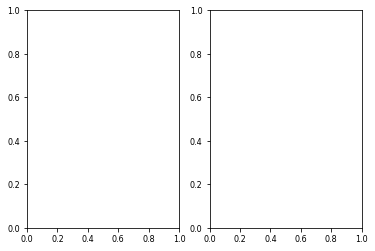

In [7]:
# generate the Non-Linear Decision (NLD) functions

# projection for ste
nld = {}
bins = {}
f, ax = plt.subplots(1,2)
for k in ste.keys():
# k = 'unit_3'
    num_spikeEvents = len(ste[k])
    num_priorEvents = len(prior_ensemble[k])
    
    projected_ste = np.dot(ste[k].iloc[:,0:600-int(TimePost*Fs)], sta[k][0:600-int(TimePost*Fs)])
    projected_prior = np.dot(prior_ensemble[k].iloc[:,0:600-int(TimePost*Fs)], sta[k][0:600-int(TimePost*Fs)])
    
    
    values, bins[k], _ = ax[0].hist([projected_ste, projected_prior], bins = 30, density = True)
    nld[k] = values[0]/values[1]
    ax[1].plot(bins[k][:-1], nld[k], 'o-')
    filename = './dataFolder/' + name + '_' + k + '_NLDS.pdf'
    plt.savefig(filename)
    ax[0].cla()
    ax[1].cla()

In [8]:
# # plot a specific nld

# k = 'unit_2'
# num_spikeEvents = len(ste[k])
# plt.plot(bins[k][:-1], final[k])
# plt.savefig('./dataFolder/m7_unit3_nld.pdf')

In [9]:
# # eigen values
# normalized_st = {}
# st_norm = {}
# k = 'unit_2'
# normalized_st[k] = ste[k].loc[0:600-int(TimePost*Fs)] - sta[k].loc[0:600-int(TimePost*Fs)]
# st_norm[k] = normalized_st[k].loc[:,0:600-int(TimePost*Fs)]
# # normalized_prior[k] = ste[k].loc[0:600-int(TimePost*Fs)] - sta[k].loc[0:600-int(TimePost*Fs)]
# # st_norm[k] = normalized_st[k].loc[:,0:600-int(TimePost*Fs)]
# # for row, s_i in st_norm[k].iterrows():
# cov_st = np.cov(st_norm[k])
# cov_prior = np.cov(prior_ensemble[k].loc[0:cov_st.shape[1]-1, :])

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

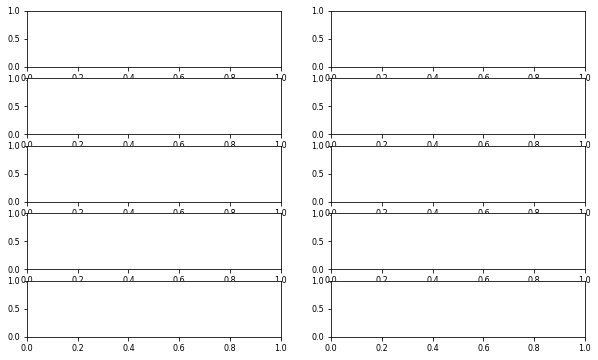

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

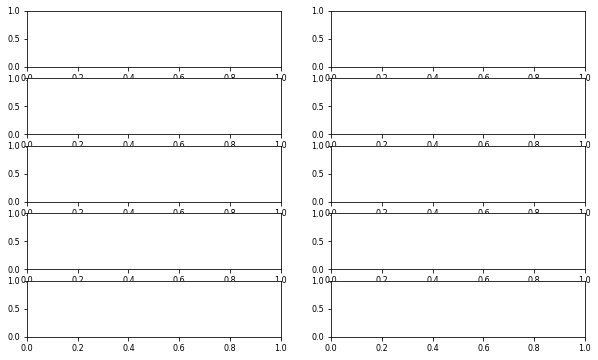

In [10]:
from scipy import linalg

s ={}
vh ={}

for k in ste.keys():
    rows = np.unique(np.where(np.isnan(ste[k]))[0]) #remove stuff with NaNs
    spike_triggered = ste[k].drop(rows, axis = 0)
    cov_st = np.cov(np.transpose(spike_triggered), bias = True)

    rows = np.unique(np.where(np.isnan(prior_ensemble[k]))[0])
    prior = prior_ensemble[k].drop(rows, axis = 0)
    cov_prior = np.cov(np.transpose(prior), bias = True)

    # plot the covariance matrices
    f = plt.figure() # plot covariance matrix
    xmin = 0
    ymin = 0
    dx = 0.25
    dy = 1

    vmin = np.min([cov_st, cov_prior])
    vmax = np.max([cov_st, cov_prior])
    
    ax0 = f.add_axes([xmin, ymin, dx, dy])
    z1 = ax0.imshow(cov_st, vmin = vmin, vmax = vmax)
    ax0.invert_yaxis()
    plt.colorbar(z1, fraction=0.046, pad=0.04)

    ax1 = f.add_axes([xmin + dx + 0.05, ymin, dx, dy])
    z2 = ax1.imshow(cov_prior, vmin = vmin, vmax = vmax)
    ax1.invert_yaxis()
    plt.colorbar(z2, fraction=0.046, pad=0.04)
    ax1.set_yticks([])

    ax2 = f.add_axes([xmin + 2*dx + 2*0.05, ymin, dx, dy])
    z3 = ax2.imshow(cov_st - cov_prior)
    ax2.invert_yaxis()
    ax2.set_yticks([])
    plt.colorbar(z3, fraction=0.046, pad=0.04)

    filename = './dataFolder/' + name + '_' + k + '_covarianceMatrix.pdf'
    plt.savefig(filename)

    plt.clf()

    # do svd and the biggest eigenmodes
    U, s_, vh_ = linalg.svd(cov_st - cov_prior)
    s[k] = s_
    vh[k] = vh_
    
    # plot eigen values
    f1 = plt.figure() # plot eigenvalues
    plt.plot(s_[0:10]**2, 'o-')
    filename = './dataFolder/' + name + '_' + k + '_EigenValues.pdf'
    plt.savefig(filename)
    plt.clf()

    # plot eigen vectors
    f2, ax = plt.subplots(5,2, figsize = (10,6)) # plot eigenvectors
    ax = ax.ravel()
    for idx, axes in enumerate(ax):
        time_ax = np.arange(0, len(vh_[idx]))*1/Fs
        ax[idx].plot(time_ax, np.flip(vh_[idx]))
        ax[idx].set_xlim(0.02, -0.002)
    filename = './dataFolder/' + name + '_' + k + '_EigenVectors.pdf'
    plt.savefig(filename)
    for axes in ax:
        axes.cla()

In [11]:
# pickle dump the timestamps
import pickle

saveObject = (ste, prior_ensemble, nld, bins, s, vh)
with open("./dataFolder/" + name + "_EncodingModel.pickle","wb") as f:
    pickle.dump(saveObject, f)